In [34]:
import torch
from dataload import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
dataset = dense_Dataset('data/embeddings.h5', 'data/densities.csv', test_perc=0.15, val_perc=0.15) 

In [36]:
train_keys, val_keys = dataset.train_keys, dataset.val_keys
train_loader = CNN_Dataloader(dataset, train_keys, batch_size=128, shuffle=True)
val_loader = CNN_Dataloader(dataset, val_keys, batch_size=128, shuffle=True)

In [17]:
hparams = {
    'epochs': 100,
    'lr':0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [18]:
model, losses_train, losses_val, outputs, targets = train_CNN(train_loader, val_loader, hparams)

starting training


Epoch 1/5: 100%|██████████| 13/13 [01:10<00:00,  5.43s/it]
D:\programming\PP1\.venv\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 5/5: 100%|██████████| 13/13 [01:10<00:00,  5.41s/it]


Best validation loss: 0.0001093353809361967


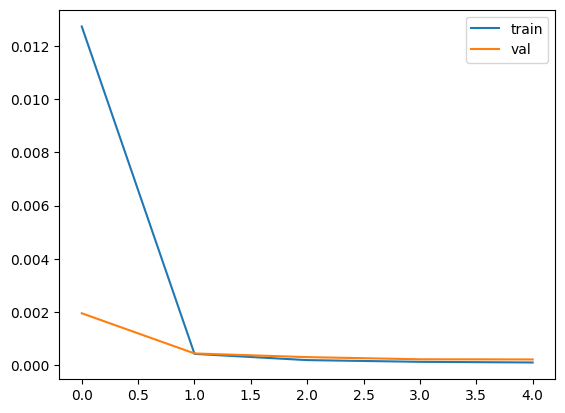

In [19]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

MSE: 0.0001706950570223853


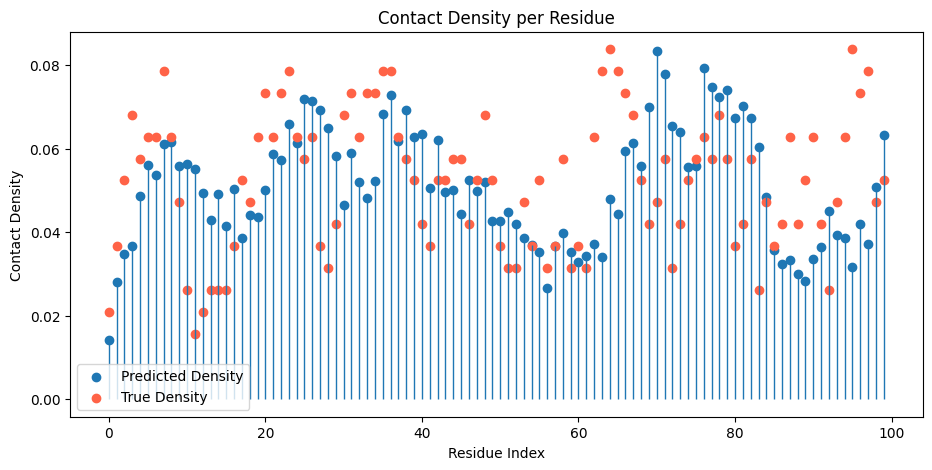

In [20]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
# truths = truths + target_mean.item()
# preds = preds + output_mean.item()
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.savefig("neural_net_big.png")
plt.show()


# OVERFIT ON ONE SAMPLE

In [26]:
overfit_hparams = {
    'epochs': 100,
    'lr':0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [30]:
# overfit on one sample
overfit_train_loader = CNN_Dataloader(dataset, train_keys[:1], batch_size=128, shuffle=True)
overfit_val_loader = CNN_Dataloader(dataset, val_keys[:1], batch_size=128, shuffle=True)


In [31]:
model, losses_train, losses_val, outputs, targets = train_CNN(overfit_train_loader, overfit_val_loader, overfit_hparams)


starting training


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


MSE: 1.0915739494521404e-06


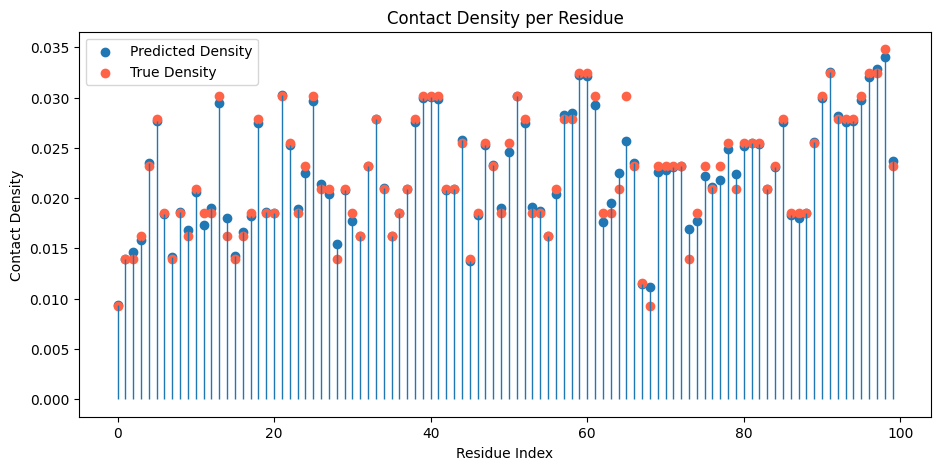

In [33]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.savefig("cnn_overfit.png")
plt.show()